## Set Up

In [1]:
# Install fastbook. Will prompt to connect to Google Drive. 
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# Getting all the required fastai modules 
from fastbook import *
from fastai.vision.all import *

In [3]:
# Set up to connect to Kaggle dataset api
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

ERROR: Operation cancelled by user


In [ ]:
# Upload Kaggle json credentials
from google.colab import files
files.upload()

{}

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
# Download dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!ls

 99% 737M/745M [00:23<00:00, 43.7MB/s]
100% 745M/745M [00:23<00:00, 32.6MB/s]
covid19-radiography-database.zip  gdrive  kaggle.json  sample_data


In [6]:
path = '/content/COVID-19_Radiography_Dataset'

In [7]:
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

Note: I could mount the dataset and Kaggle ket to a Drive folder to avoid having to do this process again. 

In [5]:
# Divides data into train, test, and validation folders
import os
import shutil
import random

class_names = ['normal', 'pneumonia', 'covid_19', 'lung_opacity']
root_dir = '/content/COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

os.mkdir(os.path.join(root_dir, 'train'))
os.mkdir(os.path.join(root_dir, 'test'))
os.mkdir(os.path.join(root_dir, 'val'))

for i, d in enumerate(source_dirs):
    os.renames(
        os.path.join(root_dir, d),
        os.path.join(root_dir, class_names[i])
    )

for c in class_names:
    os.mkdir(os.path.join(root_dir, 'test', c))
    os.mkdir(os.path.join(root_dir, 'val', c))

    images = [i for i in os.listdir(os.path.join(
        root_dir, c)) if i.lower().endswith('png')]
    test_images = random.sample(images, 60)
    images = list(set(images) - set(test_images))
    val_images = random.sample(images, 60)

    for image in test_images:
        shutil.move(
            os.path.join(root_dir, c, image),
            os.path.join(root_dir, 'test', c, image)
        )

    for image in val_images:
        shutil.move(
            os.path.join(root_dir, c, image),
            os.path.join(root_dir, 'val', c, image)
        )

    shutil.move(
        os.path.join(root_dir, c),
        os.path.join(root_dir, 'train')
    )

FileExistsError: ignored

In [7]:
# training: 20685 images, test: 240 images, val: 240 images
train = get_image_files(path+'/train')
test = get_image_files(path+'/test')
val = get_image_files(path+'/val')

print(f"Train: {len(train)}, Test: {len(test)}, Val: {len(val)}")

Train: 20685, Test: 240, Val: 240


In [ ]:
# Distribution in training data
train_covid = get_image_files(path+'/train/covid_19')
train_lungopacity = get_image_files(path+'/train/lung_opacity')
train_normal = get_image_files(path+'/train/normal')
train_pneumonia = get_image_files(path+'/train/pneumonia')

print(f"Covid: {len(train_covid)}, Lung Opacity: {len(train_lungopacity)}, Normal: {len(train_normal)}, Pneumonia: {len(train_pneumonia)}")

## Training Approach 1

In [8]:
# Define fastai DataBlock
xrays = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(train_name=('train'), valid_name = 'val'),
    get_y = parent_label,
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

Note: could be worth attempting training without augmentations. As input data will always be head on in the same way training data is. 

In [9]:
# Define fastai data loader
dls = xrays.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


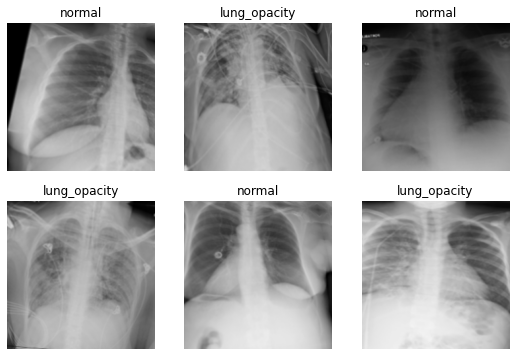

In [10]:
dls.show_batch(max_n=6, nrows=2)

In [11]:
# Define learner
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy], cbs = ShowGraphCallback() )


SuggestedLRs(valley=0.0010000000474974513)

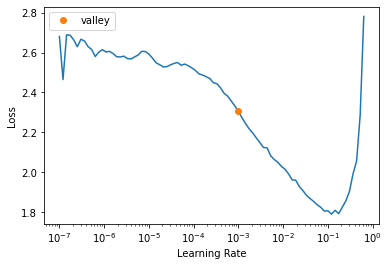

In [ ]:
# Suggested learning rate
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.878474,0.773607,0.266667,0.733333,01:35


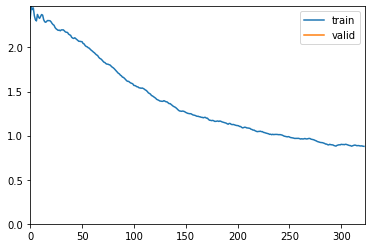

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.456961,0.407967,0.137500,0.862500,01:49
1,0.336350,0.458523,0.162500,0.837500,01:50
2,0.268586,0.366897,0.133333,0.866667,01:50


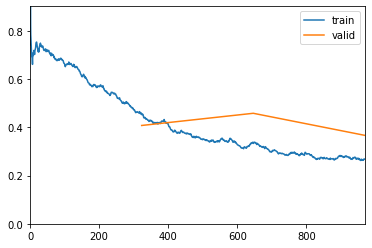

In [12]:
# Use fine tune to train model
learn.fine_tune(3,1e-3)

In [13]:
learn.validate() 

(#3) [0.36689674854278564,0.13333334028720856,0.8666666746139526]

The above cell runs validation on 240 image val dataset as defined in DataBlock. Note that this method applies transformations to images before validation. This mimiics the behvior of predict(). You can pass in another test dataset to learn.validate, however it assumes transforms have been applied. Performance will be poor if they have not. 

Below I pass in the untransformed dls.valid, for which performance will be much worse. learn.validate() runs on learn.dls.valid.

Strange, this doesn't happen now. 

In [14]:
learn.validate(dl=dls.valid)

(#3) [0.36689674854278564,0.13333334028720856,0.8666666746139526]

In [15]:
learn.validate(dl=learn.dls.valid)

(#3) [0.36689674854278564,0.13333334028720856,0.8666666746139526]

### Test Set Validation

Below I create a dataloader from my test set of previously unseen data. I then pass this to validate()

In [18]:
path = '/content/COVID-19_Radiography_Dataset/test'

xrays_test = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.5, seed=42),
    get_y = parent_label,
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [19]:
dls_test = xrays_test.dataloaders(path)
dls_test_val = dls_test.valid #dls_test_val will just be 50% of validation set as defined above.
learn.validate(dl=dls_test_val)

(#3) [2.2378742694854736,0.7333333492279053,0.2666666805744171]

Model performs much worse on this set

We can use fastai's built in interpretation to explore further. 

In [26]:
interp = ClassificationInterpretation.from_learner(learn)


We see good results, as expected, from validation set. 

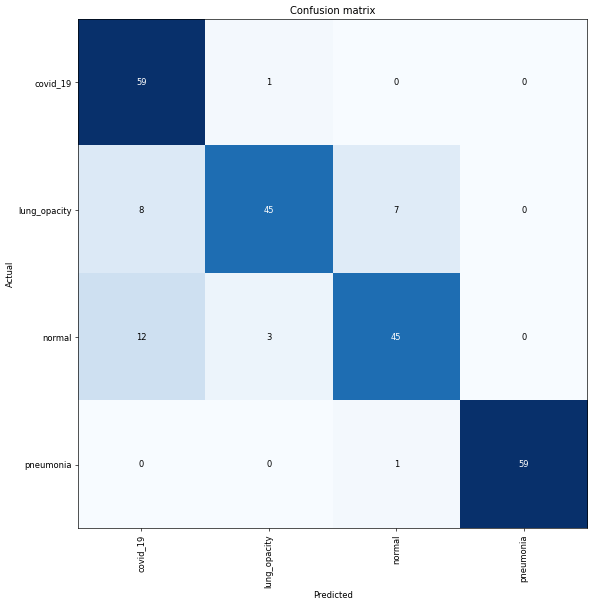

In [27]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [28]:
interp_test = ClassificationInterpretation.from_learner(learn, dl = dls_test_val)


And we see much worse results on the unseen test set

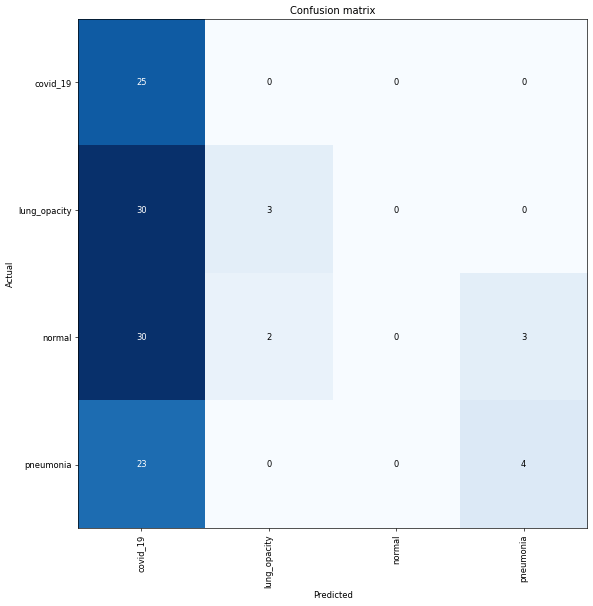

In [29]:
interp_test.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [30]:
interp_test.most_confused(min_val=5)

[('lung_opacity', 'covid_19', 30),
 ('normal', 'covid_19', 30),
 ('pneumonia', 'covid_19', 23)]

However, we **expect** the model to do poorly on the test set. This is because it doesn't have the same transformations applied to it. We have defined them in the block, but because learn() has not been called, they have not been invoked. 

The predict() function will apply these transforms to input before passing it to the model. So we can get a intutive feel for performance by passing some images from the test set and seeing how it does. 


...is this true?

These are our categories in order of how their probabilites will be shown in the response

In [31]:
learn.dls.vocab

['covid_19', 'lung_opacity', 'normal', 'pneumonia']

Now we can predict on a random image. The model does well. 

In [32]:
img = '/content/COVID-19_Radiography_Dataset/test/lung_opacity/Lung_Opacity-1108.png'
learn.predict(img)

('lung_opacity', TensorBase(1), TensorBase([0.0412, 0.6924, 0.2131, 0.0533]))

On a second attempt, it does worse. 
Not bad though. It's just a little more confident in covid than normal. 

In [33]:
img = '/content/COVID-19_Radiography_Dataset/test/normal/Normal-1811.png'
learn.predict(img)

('covid_19', TensorBase(0), TensorBase([0.5128, 0.0046, 0.4704, 0.0121]))

Does pretty good here. 

In [34]:
img = '/content/COVID-19_Radiography_Dataset/test/pneumonia/Viral Pneumonia-1273.png'
learn.predict(img)

('pneumonia',
 TensorBase(3),
 TensorBase([3.7952e-01, 8.6914e-03, 1.8158e-05, 6.1177e-01]))

Model actually doing well on stuff it hasn't seen before. 

In [50]:
img = '/content/COVID-19_Radiography_Dataset/test/lung_opacity/Lung_Opacity-2461.png'
learn.predict(img)

('lung_opacity',
 TensorBase(1),
 TensorBase([7.6045e-04, 9.9894e-01, 6.1982e-07, 2.9593e-04]))

Why does this test dls do bad?
Yesterday udnerstanding was dls.valid and dls_test both doing bad beacause transforms not applied to them. However, model did really well on learn.dls.valid because transforms applied. Also, would do well on random test image passed to predict because predict applies transforms. 

But now behavior is different.

doing the same on dsl.val and learn.dls.val. Yesterady those were both test folder. Now both val folder. Maybe fast ai automatically does something to val folder?

However, still looks bad on test batch. Which doesn't make sense now that it does well on dls.val.

But maybe I don't want to be passing in dls_test_val. Maybe I want to just have dls_test. 

One data point I should know is: if I pass in dls.val or this test dls outside of learn object...is it transformed or not?


This is another way to create a test dl
Using this method, the same transforms applied to the training validation set are applied to the test set. 

Using this, I see strong metrics. 

---



---



In [47]:
fnames = get_image_files('/content/COVID-19_Radiography_Dataset/test')
test_dl_v2 = learn.dls.test_dl(fnames, with_labels=True)
learn.validate(dl=test_dl_v2)

The fact that the metrics are strong for this test set and that they do well on individual test items leads me to believe that the set on which it performs badly does so because it is not transformed in the same way. 

So where does that leave me?

Seems model does very well on test data that is from the same original dataset. 

But, it does very poorly on images from outside of that set. It doesn't generalize well. 

There's many reasons this could be. Could be learning something particular about this set. Could be influenced by covid images in some special way: they are all newer. Could be that I don't want to apply transforms at all. 

I'll save the learner so I can reference it later. 

In [35]:
learn.export()

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf_v1 = load_learner(path/'export.pkl')

# A different model training appraoch

In [51]:
path = '/content/COVID-19_Radiography_Dataset'

train = get_image_files(path+'/train')
test = get_image_files(path+'/test')
val = get_image_files(path+'/val')

print(f"Train: {len(train)}, Test: {len(test)}, Val: {len(val)}")

Train: 20685, Test: 240, Val: 240


In [54]:
xrays2 = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42), #probably don't wanna pass valid pct
    get_y = parent_label,
    item_tfms = Resize(460),
)

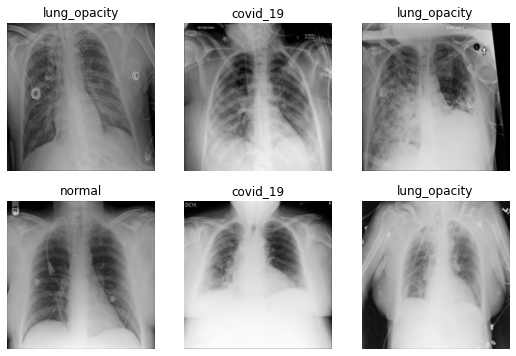

In [55]:
dls = xrays2.dataloaders(path+"/train")
dls.show_batch(max_n=6, nrows=2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.638450,0.544896,0.084844,0.915156,04:25
1,0.520001,0.503984,0.068165,0.931835,04:24


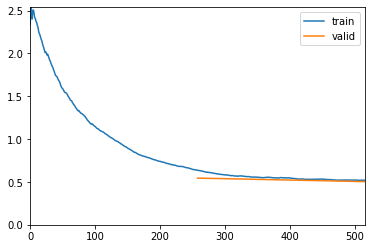

In [56]:
# fit one cycle
learn2 = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy],loss_func=LabelSmoothingCrossEntropy(), cbs=ShowGraphCallback())
learn2.fit_one_cycle(2, 3e-3)

In [59]:
learn2.unfreeze()

SuggestedLRs(valley=3.630780702224001e-05)

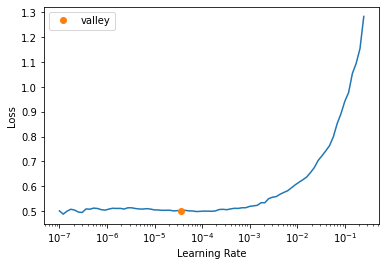

In [60]:
learn2.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.497432,0.486898,0.059705,0.940295,05:50
1,0.447519,0.475507,0.051970,0.948030,05:49
2,0.411953,0.474141,0.052695,0.947305,05:50


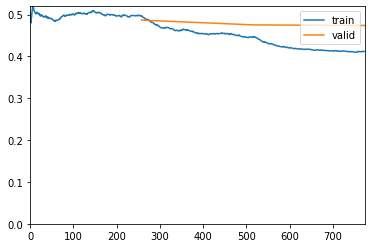

In [61]:
learn2.fit_one_cycle(3, lr_max=slice(1e-5,1e-4))

In [62]:
learn2.validate()

(#3) [0.4741407632827759,0.05269518867135048,0.9473047852516174]

In [63]:
fnames = get_image_files('/content/COVID-19_Radiography_Dataset/test')
test_dl_v2 = learn2.dls.test_dl(fnames, with_labels=True)
learn2.validate(dl=test_dl_v2)

(#3) [0.4719550311565399,0.04583333060145378,0.9541666507720947]

Seems to perform very well on both sets. 

Gets predicition right that earlier model got wrong. 

In [66]:
learn2.dls.vocab

['covid_19', 'lung_opacity', 'normal', 'pneumonia']

In [65]:
img = '/content/COVID-19_Radiography_Dataset/test/normal/Normal-1811.png'
learn2.predict(img)

('normal', TensorBase(2), TensorBase([0.0227, 0.0416, 0.9061, 0.0297]))

In [67]:
img = '/content/COVID-19_Radiography_Dataset/test/lung_opacity/Lung_Opacity-1108.png'
learn2.predict(img)

('normal', TensorBase(2), TensorBase([0.0250, 0.3006, 0.6470, 0.0275]))

In [68]:
img = '/content/COVID-19_Radiography_Dataset/test/pneumonia/Viral Pneumonia-1273.png'
learn2.predict(img)

('pneumonia', TensorBase(3), TensorBase([0.0468, 0.0993, 0.0027, 0.8512]))

## Comparing models on images from the internet


In [69]:
img = '/content/pneumoniaxray3.png'

Model 1 wrongly predicts covid.
Model 2 wrongly predcits covid.

In [70]:
learn.predict(img)

('covid_19',
 TensorBase(0),
 TensorBase([9.9599e-01, 1.2412e-06, 5.3862e-05, 3.9588e-03]))

In [71]:
learn2.predict(img)

('covid_19', TensorBase(0), TensorBase([0.9608, 0.0057, 0.0125, 0.0210]))

In [72]:
img = '/content/lungopacityxray.jpeg'

Model 1 wrongly predits covid. Model 2 wrongly predicts normal. 

In [73]:
learn.predict(img)

('covid_19',
 TensorBase(0),
 TensorBase([9.7931e-01, 3.2597e-04, 1.8591e-02, 1.7743e-03]))

In [74]:
learn2.predict(img)

('normal', TensorBase(2), TensorBase([0.3560, 0.0525, 0.5652, 0.0263]))

In [76]:
img = '/content/normal-lung.png'

Model 1 correctly predicts normal. Model 2 wrongly predicts covid. 

In [77]:
learn.predict(img)

('normal', TensorBase(2), TensorBase([0.2555, 0.0027, 0.7097, 0.0321]))

In [78]:
learn2.predict(img)

('covid_19', TensorBase(0), TensorBase([0.7672, 0.0111, 0.1457, 0.0759]))

## Concluding thoughts for now

We see that both models do very well on their validation sets. They also do well on the unseen test set from the original data.

However, their performance falls apart when called to make predictions on x-rays from the internet. 

There are many many reasons this might be happening. Diagnoses the root issue would require systems thinking, various experiments, and possibly help from someone with subect matter expertise. Some things that could be going on for example


*   The model has learned something particular to this dataset and does not generalize well.
* Some digital property of the images from the web does not work well when fed into this model. This could have to do with sizing, file types, etc.
*   Images are being correctly classified and the labels on the internet are wrong
* At least the covid images in this dataset are relatively new. If x-ray quality has changed over time, the model may be able to detect age and could inappropriately be factoring that in. I.e. first search images are new and new images are more likely to be covid.


## Some interesting notes
* The model performances seem to be relatively similar. In the second model, we have removed the data transforms. In this case it makes sense why these might not be helpful - as input data will, like the training set, always be head on. 

